In [16]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.io import wavfile

# %matplotlib notebook



def read_arduino(ser,inputBufferSize):
#     data = ser.readline((inputBufferSize+1)*2)
    data = ser.read((inputBufferSize+1)*2)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return np.flip(np.array(result)-512)



# ser.read works by waiting for <inputBufferSize> bytes from the port

def read_arduinbro(wav_array, inputBufferSize, k):
#    data = ser.readline(inputBufferSize)
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)





In [17]:
# # use this to find ports
# from serial.tools import list_ports

# ports = list_ports.comports()
# for port in ports:
#     print(port)
    



# # Read example data
# baudrate = 230400
# cport = '/dev/cu.usbmodem142301'  # set the correct port before you run it
# ser = serial.Serial(port=cport, baudrate=baudrate)   

# inputBufferSize = 10000 # 20000 = 1 second

 

In [18]:
# Load training set

import os

path = "/Users/darap/Documents/School/University/2021, Sem. 1/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/"


files = os.listdir(path)

waves = {}
labels = {}

for file in files:
    #print(file)
    if ("right" in file.lower() or "left" in file.lower()) and "blink" not in file.lower():
        if file[-4::] == ".wav":
            samprate, wav_array = wavfile.read(path+file)
            print(samprate)
            waves[file[:-4]] = wav_array
        elif file[-4::] == ".txt":
            labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
            labels_dat.columns = ["label", "time"]
            # Change depending on whether L is coded as 1 or as 2
            labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]

            labels[file[:-4].replace(".", "")] = labels_dat
            print(list(labels[file[:-4].replace(".", "")].label))

print(waves.keys(), labels.keys())


print(set(waves.keys()).difference(set(labels.keys())))
print(set(labels.keys()).difference(set(waves.keys())))

assert set(waves.keys()).difference(set(labels.keys())) == set() and set(labels.keys()).difference(set(waves.keys())) == set()




['L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'L', 'R', 'L', 'R', 'R']
10000
['L', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'L']
10000
['L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R']
10000
['L', 'L', 'R', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'L']
10000
['L', 'L', 'R', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'R', 'R', 'L', 'L', 'R', 'R']
10000
['L', 'L', 'L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'L', 'L', 'R', 'R', 'L', 'R', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'R']
10000
['L', 'L', 'R', 'R', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'R']
10000
['R', 'R', 'R', 'R', 'L', 'L', 'R', 'R', 'R', 'L', 'L', 'R', 'R', 'R', 'R', 'L', 'R']
10000
['R', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'R', 'R', 'R']
10000
['L', 'L', 'R', 'R', '

In [19]:
# Simulate stream

# with wave.open('/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Spiker_box_Louis/Short/LLL_L2.wav','r') as wav:
#     framerate = wav.getframerate()
#     nframes = wav.getnframes()
samprate = 10000.0
#     wav_array = np.array(struct.unpack("<" + "h"*nframes, wav.readframes(nframes)))
    

In [20]:
from scipy import signal


def classify_event(arr, downsample_rate=10, window_size_seconds=0.3):
    #print("smoothing classifier")
    arr_ds = arr[0::downsample_rate]
    
    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    start = time.time()
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)
    end = time.time()
    #print("Sav-Gol took:", end - start, "seconds")

    # Get max min
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    
    
#     mins = arr_ds[min_locs]
#     mins = arr_ds[min_locs]
    
    
    max_min_locs = np.append(max_locs, min_locs)
    max_min = arr_ds[max_min_locs]

    # Sort vals    
    top_3 = sorted(max_min, key=abs, reverse=True)[0:3]

    if np.sum(np.sign(top_3)) == 1:
        return "L"
    elif np.sum(np.sign(top_3)) == -1:
        return "R"
    else:
        return "_"
    
    
    
def classify_event(arr, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    #print("smoothing classifier")
    arr_ds = arr[0::downsample_rate]
    
    fs = samprate/downsample_rate;
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    start = time.time()
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)
    end = time.time()
    #print("Sav-Gol took:", end - start, "seconds")

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    # Appended indices
    max_min_locs = np.append(max_locs, min_locs)
    
    # Values of above indices
    max_min_values = filtered_arr[max_min_locs]
    # Absolute value of those values
    abs_max_min_values = np.abs(max_min_values)
    
    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)
    # A vector with a length equal to the number of maximums: all '1' to say maximum
    numMax = [1]*len(max_locs)
    
    # Vector same size as max_min_values with first half being maximums and second half being minimums
    isMin = np.append(numMax, numMin)
    
    # Stack the three vectors
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]
    

    
    classificationFound = False
    
    # We will continue looping until we have an appropriate classification. This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    while not classificationFound and loops < max_loops:
        
        # Take the top three magnitudes
        top_3 = val_and_idx_sorted[:, 0:3]
        
        # Sort according to the indices of those values
        top_3_sorted = top_3[ :, top_3[1].argsort()]
        
        # Break if we run out of turning points
        if top_3_sorted.shape != (3, 3):
            return "_"
        
        # If two min or two max occur one after the other, we know we have an inappropriate result so we delete one of those doubled min/max
        if top_3_sorted[2, 0]*top_3_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        elif top_3_sorted[2, 1]*top_3_sorted[2, 2] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 2, 1)
        else:
            classificationFound = True
        
        loops += 1
    
    if np.sum(top_3_sorted[2, :]) == -1:
        return 'L'
    elif np.sum(top_3_sorted[2, :]) == 1:
        return 'R'
    else:
        return "_"



In [21]:
#Looks for x samples (after downsampling) that are consecutively positive / negative.
#Classifies only using the first hump of the wave.
from numba import njit

@njit
def zeroes_classifier(arr, downsample_rate=10, window_size_seconds=0.3, ave_height = 200):
    #print("zeroes_classifier")
    arr_ds = arr[0::downsample_rate]
    arr_sign = np.sign(arr_ds)

    consec_neg = 0
    consec_pos = 0
    i = 0
    while i < len(arr_sign):
        if consec_neg == 0 and consec_pos == 0:
            if arr_sign[i] == 1:
                consec_pos += 1
            if arr_sign[i] == -1:
                consec_neg += 1
        if consec_neg > 0:
            if arr_sign[i] == 1:
                consec_neg = 0
                consec_pos = 1
            elif arr_sign[i] == -1:
                consec_neg += 1
                consec_pos = 0
            elif arr_sign[i] == 0:
                consec_neg, consec_pos = 0, 0
        if consec_pos > 0:
            if arr_sign[i] == -1:
                consec_pos = 0
                consec_neg = 1
            elif arr_sign[i] == 1:
                consec_pos += 1
                consec_neg = 0
            elif arr_sign[i] == 0:
                consec_neg, consec_pos = 0, 0

        if consec_neg > 200:
            if np.sum(arr_ds[i - 200: i]) / 200 < -1 * ave_height:
                return 'L'          
        if consec_pos > 200:
            if np.sum(arr_ds[i - 200: i]) / 200 > ave_height:
                return 'R'
        i += 1
    return '_'


In [22]:
# SINCE THE STREAMING DATA COMES IN FROM THE RIGHT TO THE LEFT ON THE PLOT, 
# THE RESULTANT PLOT IS ACTUALLY REFLECTED ABOUT THE Y AXIS


def streaming_classifier(
    wav_array,
    window_size = 1.5, # time plotted in window [s]
    N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
    samprate = 10000,
    total_time = None,  # max time
    hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off either end of the window in order to define the middle portion
    hyp_detection_buffer_start = 0.7,
    hyp_event_threshold = 1800, # crossings per second
    hyp_event_history = 5,
    hyp_consecutive_triggers = 3,
    hyp_consecutive_reset = 1,
    plot = False,
    store_events = False, 
    verbose=False
):
    
    #print("old streaming classifier")
    if total_time is None:
        total_time = len(wav_array)/samprate
    if store_events:
        predictions_storage = []
    
    predictions = ""
    predictions_timestamps = []

    
    # Initialise variables
    inputBufferSize = int(window_size/N_loops_over_window * samprate)
    N_loops =(total_time*samprate)//inputBufferSize  # len(wav_array)//inputBufferSize 
    T_acquire = inputBufferSize/samprate    # length of time that data is acquired for
    N_loops_over_window = window_size/T_acquire    # total number of loops to cover desire time window
    """
    print("inputBufferSize: ", inputBufferSize)
    print("N_loops: ", N_loops)
    print("T_acquire: ", T_acquire)
    print("N_loops_over_window: ", N_loops_over_window)
    """

    # Initialise plot
    if plot:
        min_y = -2000 #np.min(wav_array)
        max_y = 2000 #np.max(wav_array)
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        plt.ion()
        fig.show()
        fig.canvas.draw()


    # Hyperparameter conversions
    hyp_detection_buffer_start_ind = int(round(hyp_detection_buffer_start * samprate))
    hyp_detection_buffer_end_ind = int(round(hyp_detection_buffer_end * samprate))


    event_history = np.array([False]*hyp_event_history)
    primed = True

    for k in range(0,int(N_loops)):
        
        # Simulate stream
        data_temp = read_arduinbro(wav_array, inputBufferSize, k)

        # Stream
    #     data = read_arduino(ser,inputBufferSize)
    #     data_temp = process_data(data)


        if k < N_loops_over_window:
            if k==0:
                data_plot = data_temp
            else:
                data_plot = np.append(data_temp,data_plot)

            continue
        else:
            data_plot = np.roll(data_plot,len(data_temp))
            data_plot[0:len(data_temp)] = data_temp


        ### CLASSIFIER ###
        
        ## EVENT DETECTION ##

        interval = data_plot[hyp_detection_buffer_start_ind:-hyp_detection_buffer_end_ind] # Take middle part of window


    #     test_stat = np.sum(interval[0:-1] * interval[1::] <= 0) # Calculate test stat (zero crossings) 
        test_stat = np.max(interval) - np.min(interval) # Calculate test stat (range) 
        test_stat = test_stat/(len(interval)/samprate) # convert to crossings per second


        is_event = (test_stat > hyp_event_threshold) # Test threshold

        ## KEEP HISTORY ##

        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event


        ## Classification

        if np.all(event_history[0:hyp_consecutive_triggers]) and primed:
            start = time.time()
            prediction = classify_event(data_plot)
            end = time.time()
            print("Classification took: ", end - start, "seconds.") if verbose else None
            
            print(f"CONGRATULATIONS, ITS AN {prediction}!") if verbose else None

            if store_events:
                predictions_storage.append(data_plot)
                
            predictions += prediction
            
            
            end_time = round(k*inputBufferSize/samprate, 2)
            start_time = round(end_time - window_size, 2)
            predictions_timestamps.append((start_time, end_time))
            
            timer = 20

            primed = False
        elif np.all(~event_history[0:hyp_consecutive_reset]):
            primed = True



        ## PLOT ###

        if plot:
            t = (min(k+1,N_loops_over_window))*inputBufferSize/samprate*np.linspace(0,1,(data_plot).size)
            ax1.clear()
            # Debugging Annotations
            if np.all(event_history[0:hyp_consecutive_triggers]) and timer >0:
                ax1.annotate(f"ITS AN {prediction}!!!", (window_size/2, max_y-50))
                timer -= 1
            
            ax1.annotate(f"{event_history}", (window_size/2, max_y-70))
            ax1.set_xlim(0, window_size)
            ax1.set_ylim(min_y, max_y)
            plt.xlabel('time [s]')
            ax1.plot(t,data_plot)
            fig.canvas.draw()    
            plt.show()
    
    if store_events:
        return predictions, predictions_timestamps, predictions_storage
    else:
        return predictions, predictions_timestamps
    
    

In [23]:
def new_streaming_classifier(
    wav_array,
    window_size = 1.5, # time plotted in window [s]
    N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
    samprate = 10000,
    total_time = None,  # max time
    hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off either end of the window in order to define the middle portion
    hyp_detection_buffer_start = 0.7,
    hyp_event_threshold = 1800, # crossings per second
    hyp_event_history = 5,
    hyp_consecutive_triggers = 3,
    hyp_consecutive_reset = 1,
    plot = False,
    store_events = False, 
    verbose=False
):
    
    #print("new streaming classifier!")
    if total_time is None:
        total_time = len(wav_array)/samprate
    if store_events:
        predictions_storage = []
    
    predictions = ""
    predictions_timestamps = []

    
    # Initialise variables
    inputBufferSize = int(window_size/N_loops_over_window * samprate)
    N_loops = (total_time*samprate)//inputBufferSize  # len(wav_array)//inputBufferSize 
    T_acquire = inputBufferSize/samprate    # length of time that data is acquired for 
    N_loops_over_window = window_size/T_acquire    # total number of loops to cover desire time window


    # Initialise plot
    if plot:
        min_y = -2000 #np.min(wav_array)
        max_y = 2000 #np.max(wav_array)
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        plt.ion()
        fig.show()
        fig.canvas.draw()


    # Hyperparameter conversions
    hyp_detection_buffer_start_ind = int(round(hyp_detection_buffer_start * samprate))
    hyp_detection_buffer_end_ind = int(round(hyp_detection_buffer_end * samprate))


    event_history = np.array([False]*hyp_event_history)
    primed = True

    for k in range(0,int(N_loops)):
        
        # Simulate stream
        data_temp = read_arduinbro(wav_array, inputBufferSize, k)

        # Stream
    #     data = read_arduino(ser,inputBufferSize)
    #     data_temp = process_data(data)


        if k < N_loops_over_window:
            if k==0:
                data_plot = data_temp
            else:
                data_plot = np.append(data_temp,data_plot)

            continue
        else:
            data_plot = np.roll(data_plot,len(data_temp))
            data_plot[0:len(data_temp)] = data_temp


        ### CLASSIFIER ###
        
        ## EVENT DETECTION ##

        interval = data_plot[hyp_detection_buffer_start_ind:-hyp_detection_buffer_end_ind] # Take middle part of window


    #     test_stat = np.sum(interval[0:-1] * interval[1::] <= 0) # Calculate test stat (zero crossings) 
        test_stat = np.max(interval) - np.min(interval) # Calculate test stat (range) 
        test_stat = test_stat/(len(interval)/samprate) # convert to crossings per second


        is_event = (test_stat > hyp_event_threshold) # Test threshold

        ## KEEP HISTORY ##

        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event


        ## Classification

        if np.all(event_history[0:hyp_consecutive_triggers]) and primed:
            start = time.time()
            prediction = zeroes_classifier(data_plot)
            end = time.time()
            print("Classification took: ", end - start, "seconds.") if verbose else None
            
            print(f"CONGRATULATIONS, ITS AN {prediction}!") if verbose else None

            if store_events:
                predictions_storage.append(data_plot)
                
            predictions += prediction
            
            
            end_time = round(k*inputBufferSize/samprate, 2)
            start_time = round(end_time - window_size, 2)
            predictions_timestamps.append((start_time, end_time))
            
            timer = 20

            primed = False
        elif np.all(~event_history[0:hyp_consecutive_reset]):
            primed = True



        ## PLOT ###

        if plot:
            t = (min(k+1,N_loops_over_window))*inputBufferSize/samprate*np.linspace(0,1,(data_plot).size)
            ax1.clear()
            # Debugging Annotations
            if np.all(event_history[0:hyp_consecutive_triggers]) and timer >0:
                ax1.annotate(f"ITS AN {prediction}!!!", (window_size/2, max_y-50))
                timer -= 1
            
            ax1.annotate(f"{event_history}", (window_size/2, max_y-70))
            ax1.set_xlim(0, window_size)
            ax1.set_ylim(min_y, max_y)
            plt.xlabel('time [s]')
            ax1.plot(t,data_plot)
            fig.canvas.draw()    
            plt.show()
    
    if store_events:
        return predictions, predictions_timestamps, predictions_storage
    else:
        return predictions, predictions_timestamps

In [24]:
def plot_predictions(wav_array, labels_dat, predictions, predictions_timestamps, ax, i,
                     title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.2,
                     wave_alpha=1, pred_alpha = 0.5):
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool
        
    left_preds_bool = np.array([False]*len(time_seq))
    right_preds_bool = np.array([False]*len(time_seq))
    idk_preds_bool = np.array([False]*len(time_seq))
    for pred, times in zip(predictions, predictions_timestamps):
        if pred == "L":
            left_preds_bool = ( (time_seq > times[0]) & (time_seq < times[1]) ) | left_preds_bool
        elif pred == "R":
            right_preds_bool = ( (time_seq > times[0]) & (time_seq < times[1]) ) | right_preds_bool
        else:
            idk_preds_bool = ( (time_seq > times[0]) & (time_seq < times[1]) ) | idk_preds_bool
            

    ax[i].plot(time_seq, wav_array, alpha=wave_alpha)

    
    # Plot actuals
    ax[i].fill_between(time_seq, 2500, -2500,
                     where = left_events_bool,
                     color = 'g',
                     label = "L",
                     alpha=actual_alpha)

    ax[i].fill_between(time_seq, 2500, -2500,
                     where = right_events_bool,
                     color = 'r',
                     label = "R",
                     alpha=actual_alpha)
    
    # Plot predictions
    ax[i].fill_between(time_seq, 2500, -2500,
                     where = left_preds_bool,
                     color = 'g',
                     label = "Pred L",
                     alpha=pred_alpha)

    ax[i].fill_between(time_seq, 2500, -2500,
                     where = right_preds_bool,
                     color = 'r',
                     label = "Pred R",
                     alpha=pred_alpha)
    
    ax[i].fill_between(time_seq, 2500, -2500,
                     where = idk_preds_bool,
                     color = 'y',
                     label = "Pred idk",
                     alpha=pred_alpha)
    
    ax[i].set_title(key)
    ax[i].legend()






SUMMARY OF OLD CLASSIFIER:
Time taken:  1.3063769340515137
Average efficiency:  0.0033356062835292596
Average levenshtein distance:  0.3463318089688874


<AxesSubplot:>

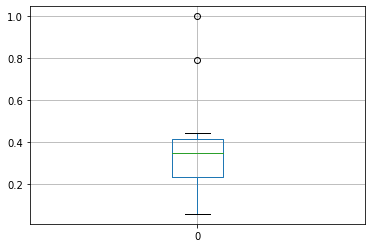

In [31]:
from copy import deepcopy
from Levenshtein import distance as levenshtein_distance 

# %matplotlib notebook
big_start = time.time()
before_buffer = 0.7
after_buffer = 1

"""
fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches(10, 3*len(waves))
"""

efficiency = []
lev_dists = []


i=0
for key in waves.keys():
    start = time.time()
    predictions, predictions_timestamps, predictions_storage = streaming_classifier(waves[key],
                                                                                    window_size=2,
                                                                                    N_loops_over_window = 20,
                                                                                    hyp_detection_buffer_end = 0.1, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                                    hyp_detection_buffer_start = 1,
                                                                                    hyp_event_history = 10,
                                                                                    hyp_consecutive_triggers = 6,
                                                                                    store_events=True)
    
    end = time.time()
    efficiency.append((end - start) / max(len(predictions) ,len(list(labels[key].label))))
    #print("streaming_classifier took: ", (end - start) / len(predictions), "seconds per classification (", len(predictions), " predictions took ", end - start,"seconds ).")
    lev_dists.append(levenshtein_distance(predictions, "".join(list(labels[key].label))) / max(len(predictions) ,len(list(labels[key].label))))
    #print(list(labels[key].label))
    
    """
    plot_predictions(waves[key], labels[key], predictions, predictions_timestamps, ax, i, title=key, actual_alpha=0.2)
    ax[i].set_xlim(-13)
    i+=1
    """
    
    actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
    actual_leftovers = deepcopy(actual_times)
    pred_leftovers = deepcopy(predictions_timestamps)
    
    
    for act_times in actual_times:
        for pred_times in predictions_timestamps:
            if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                actual_leftovers.remove(act_times)
                pred_leftovers.remove(pred_times)
            
    """            
    print("File: ", key)
    print(f"False negative triggers: {len(actual_leftovers)}", actual_leftovers)
    print(f"False positive triggers: {len(pred_leftovers)}",  pred_leftovers)
    """
    #print((len(actual_leftovers) + len(pred_leftovers)) / len(labels[key].label))
    
big_end = time.time()
%matplotlib inline
print("\n\n\n\n")
print("SUMMARY OF OLD CLASSIFIER:")
print("Time taken: ", big_end - big_start) 
#print("List of Efficiencies: ", efficiency)
print("Average efficiency: ", sum(efficiency) / len(efficiency))
#print("lev dists: ", lev_dists)
print("Average levenshtein distance: ", sum(lev_dists) / len(lev_dists))
lev_dists = pd.DataFrame(lev_dists)
lev_dists.boxplot()







SUMMARY OF NEW CLASSIFIER: (need to run twice for best speed)
Time taken:  0.9350087642669678
Average efficiency:  0.0023975819642261757
Average levenshtein distance:  0.32471640482252345


<AxesSubplot:>

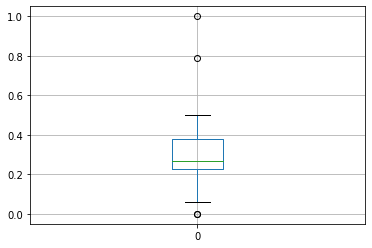

In [30]:
from copy import deepcopy
from Levenshtein import distance as levenshtein_distance 

# %matplotlib notebook
big_start = time.time()
before_buffer = 0.7
after_buffer = 1

"""
fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches(10, 3*len(waves))
"""

efficiency = []
lev_dists = []


i=0
for key in waves.keys():
    start = time.time()
    predictions, predictions_timestamps, predictions_storage = new_streaming_classifier(waves[key],
                                                                                    window_size=2,
                                                                                    N_loops_over_window = 20,
                                                                                    hyp_detection_buffer_end = 0.1, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                                    hyp_detection_buffer_start = 1,
                                                                                    hyp_event_history = 10,
                                                                                    hyp_consecutive_triggers = 6,
                                                                                    store_events=True)
    
    end = time.time()
    efficiency.append((end - start) / max(len(predictions) ,len(list(labels[key].label))))
    #print("streaming_classifier took: ", (end - start) / len(predictions), "seconds per classification (", len(predictions), " predictions took ", end - start,"seconds ).")
    lev_dists.append(levenshtein_distance(predictions, "".join(list(labels[key].label))) / max(len(predictions) ,len(list(labels[key].label))))
    #print(list(labels[key].label))
    
    """
    plot_predictions(waves[key], labels[key], predictions, predictions_timestamps, ax, i, title=key, actual_alpha=0.2)
    ax[i].set_xlim(-13)
    i+=1
    """
    
    actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
    actual_leftovers = deepcopy(actual_times)
    pred_leftovers = deepcopy(predictions_timestamps)
    
    
    for act_times in actual_times:
        for pred_times in predictions_timestamps:
            if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                actual_leftovers.remove(act_times)
                pred_leftovers.remove(pred_times)
    

    """            
    print("File: ", key)
    print(f"False negative triggers: {len(actual_leftovers)}", actual_leftovers)
    print(f"False positive triggers: {len(pred_leftovers)}",  pred_leftovers)
    """
    #print((len(actual_leftovers) + len(pred_leftovers)) / len(labels[key].label))
    
big_end = time.time()
%matplotlib inline
print("\n\n\n\n")
print("SUMMARY OF NEW CLASSIFIER: (need to run twice for best speed)")
print("Time taken: ", big_end - big_start) 
#print("List of Efficiencies: ", efficiency)
print("Average efficiency: ", sum(efficiency) / len(efficiency))
#print("lev dists: ", lev_dists)
print("Average levenshtein distance: ", sum(lev_dists) / len(lev_dists))
lev_dists = pd.DataFrame(lev_dists)
lev_dists.boxplot()

In [27]:
#import IPython
def smooth_wave(arr,t, downsample_rate=10, window_size_seconds=0.3):
    arr_ds = arr[0::downsample_rate]
    t_ds = t[0::downsample_rate]
    
    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)
    
    return t_ds, filtered_arr

In [28]:
start = time.time()
print(len(predictions_storage))

# fig, ax = plt.subplots(8, 3)

# fig.set_size_inches(5, 15)    

%matplotlib notebook
    
    
i=0
for key in waves.keys():
    
    print(key)
    if key == "left-right":
        continue
    
    window_size = 2
    predictions, predictions_timestamps, predictions_storage = streaming_classifier(waves[key],
                                                                                    window_size=2,
                                                                                    N_loops_over_window = 20,
                                                                                    hyp_detection_buffer_end = 0.1, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                                    hyp_detection_buffer_start = 1,
                                                                                    hyp_event_history = 7,
                                                                                    hyp_consecutive_triggers = 6,
                                                                                    store_events=True)
    
    
    t = np.linspace(0, window_size, window_size*samprate)
    
    for arr, pred, act in zip(predictions_storage, predictions, labels[key].label):
        
        if pred != act:
            print(key, i)
            t_ds, smooth_arr = smooth_wave(arr,t, downsample_rate=10, window_size_seconds=0.3)
            
            plt.figure()
            plt.plot(t*samprate, np.flip(arr))
            plt.plot(t_ds*samprate, np.flip(smooth_arr))

            plt.ylim(-2500, 2500)

            plt.title(f"Predicted: {pred}, Actual: {act}")
            plt.show()
        
        
        
        i+=1
    
end = time.time()
print(end - start)

18
fast-left-middle-right-steph


TypeError: 'float' object cannot be interpreted as an integer